In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc, os



from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
#Feature Selection

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns

In [3]:
## Import all quarter data
q1_2017 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2017_Q1.csv')
q2_2017 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2017_Q2.csv')
q3_2017 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2017_Q3.csv')
q4_2017 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2017_Q4.csv')

q1_2018 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2018_Q1.csv')
q2_2018 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2018_Q2.csv')
q3_2018 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2018_Q3.csv')
q4_2018 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2018_Q4.csv')

q1_2019 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2019_Q1.csv')
q2_2019 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2019_Q2.csv')
q3_2019 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2019_Q3.csv')
q4_2019 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2019_Q4.csv')


In [4]:
#Station Data

station_data = pd.read_csv("C:/DPA Project/data/Divvy_Bicycle_Stations.csv")
station_data.head()

,ID,Station Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location
0,675,HQ QR,7,7,In Service,41.889914,-87.680343,"(41.88991358344108, -87.68034316599368)"
1,418,Ellis Ave & 53rd St,11,11,In Service,41.799336,-87.600958,"(41.79933626261, -87.6009581145)"
2,249,Montrose Harbor,31,31,In Service,41.963982,-87.638181,"(41.963982, -87.638181)"
3,322,Kimbark Ave & 53rd St,19,19,In Service,41.799568,-87.594747,"(41.799568, -87.594747)"
4,168,Michigan Ave & 14th St,19,19,In Service,41.864059,-87.623727,"(41.864059, -87.623727)"


In [5]:
## Rename q1_2018 & q2_2019 columns to match others
q1_2018.rename(columns={'01 - Rental Details Rental ID':'trip_id', '01 - Rental Details Local Start Time':'start_time','01 - Rental Details Local End Time':'end_time','01 - Rental Details Bike ID':'bikeid','01 - Rental Details Duration In Seconds Uncapped':'tripduration','03 - Rental Start Station ID':'from_station_id', '03 - Rental Start Station Name':'from_station_name','02 - Rental End Station ID':'to_station_id','02 - Rental End Station Name':'to_station_name', 'User Type':'usertype', 'Member Gender':'gender','05 - Member Details Member Birthday Year':'birthyear'}, inplace=True)

q2_2019.rename(columns={'01 - Rental Details Rental ID':'trip_id', '01 - Rental Details Local Start Time':'start_time','01 - Rental Details Local End Time':'end_time','01 - Rental Details Bike ID':'bikeid','01 - Rental Details Duration In Seconds Uncapped':'tripduration','03 - Rental Start Station ID':'from_station_id', '03 - Rental Start Station Name':'from_station_name','02 - Rental End Station ID':'to_station_id','02 - Rental End Station Name':'to_station_name', 'User Type':'usertype', 'Member Gender':'gender','05 - Member Details Member Birthday Year':'birthyear'}, inplace=True)


In [6]:
## Concatenate all 3 years of data
df = pd.concat([q1_2017, q2_2017, q3_2017, q4_2017,q1_2018, q2_2018, q3_2018, q4_2018, q1_2019,q2_2019,q3_2019,q4_2019])

In [7]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(4)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
missing_values_table(df)

Your selected dataframe has 12 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
gender,1958538,17.4091
birthyear,1930718,17.1618


In [9]:
#Merging Total Docks, To Latitude & To Longitude Data in Dataframe
df['total_docks'] =  df['from_station_id'].map(station_data.set_index('ID')['Total Docks'])
df['to_latitude'] = df['to_station_id'].map(station_data.set_index('ID')['Latitude'])
df['to_longitude'] = df['to_station_id'].map(station_data.set_index('ID')['Longitude'])
df['from_latitude'] = df['from_station_id'].map(station_data.set_index('ID')['Latitude'])
df['from_longitude'] = df['from_station_id'].map(station_data.set_index('ID')['Longitude'])

In [10]:
##Calculating Distnace between origin and destination using lat long

from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

#Get distance between pairs of lat-lon points
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
  return dist
df['dist_mts'] = Distance(df['to_latitude'].tolist(),df['to_longitude'].tolist(),df['from_latitude'].tolist(),df['from_longitude'].tolist())

In [11]:
#Correcting the data type of tripduration field testing dataset
#df['tripduration'].str.replace(',', '')
#df['tripduration'].apply(lambda x:float(x))

df['tripduration'] = pd.to_numeric(df['tripduration'], errors='coerce')

In [12]:
#Adding revenue column basis tripduration charging $3/ 30 minutes ride
df['revenue'] = (df['tripduration']/1800) * 3

In [13]:
df['from_station_id'].describe()

count    1.125010e+07
mean     1.904959e+02
std      1.437865e+02
min      1.000000e+00
25%      7.600000e+01
50%      1.650000e+02
75%      2.840000e+02
max      6.730000e+02
Name: from_station_id, dtype: float64

In [14]:
## Find the number of check-outs per station
station_counts_from = pd.DataFrame(df['from_station_id'].value_counts())

In [15]:
## Find the number of check-ins per station
station_counts_to= pd.DataFrame(df['to_station_id'].value_counts())

In [16]:
## Create a DataFrame with the check-outs and check-ins
## Create a columns that sums check-outs and check-ins
station_counts = pd.concat([station_counts_from, station_counts_to], axis=1)
station_counts.rename(columns={'from_station_id':'checkouts', 'to_station_id':'checkins'}, inplace=True)
station_counts['total'] = station_counts['checkouts'] + station_counts['checkins']

In [17]:
## After some research, we will use the top stations with checkin+checkout >50,000
## Stations have a total > 50,000
station_counts_50k = station_counts[station_counts.total>50000]
stations = list(station_counts_50k.index)

In [18]:
## Extract just trips that involve the stations with total checkin checkout > 50K in the model
q2_stations = df[(df['from_station_id'].isin(stations)) | (df['to_station_id'].isin(stations))]

In [19]:
q2_stations.head(3)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,total_docks,to_latitude,to_longitude,from_latitude,from_longitude,dist_mts,revenue
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857.0,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,23.0,41.855136,-87.654127,41.885637,-87.641823,3538.412951,1.428333
1,13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236.0,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0,31.0,41.890359,-87.617532,41.891466,-87.626761,775.740536,0.393333
3,13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288.0,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0,27.0,41.894503,-87.617854,41.893992,-87.629318,953.063652,0.480000


In [20]:
## Explore the number of trips overall and in our model

total_trip_count = df['trip_id'].count()
top_50k_count = q2_stations['trip_id'].count()
percent = round(top_50k_count/total_trip_count, 3) * 100

print("Of the {} total trips, {} involve one of our top stations. That's {}%".format(total_trip_count, 
                                                                                    top_50k_count,
                                                                                    percent))

Of the 11250100 total trips, 9638194 involve one of our top stations. That's 85.7%


In [21]:
## Convert the 'start_time' column to a datetime object
q2_stations['start_time'] = pd.to_datetime(q2_stations['start_time'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
q2_stations.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,total_docks,to_latitude,to_longitude,from_latitude,from_longitude,dist_mts,revenue
0,13518905,2017-03-31 23:59:07,4/1/2017 00:13:24,5292,857.0,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,23.0,41.855136,-87.654127,41.885637,-87.641823,3538.412951,1.428333
1,13518904,2017-03-31 23:56:25,4/1/2017 00:00:21,4408,236.0,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0,31.0,41.890359,-87.617532,41.891466,-87.626761,775.740536,0.393333
3,13518902,2017-03-31 23:54:46,3/31/2017 23:59:34,4915,288.0,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0,27.0,41.894503,-87.617854,41.893992,-87.629318,953.063652,0.480000
4,13518901,2017-03-31 23:53:33,4/1/2017 00:00:28,4247,415.0,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0,19.0,41.909668,-87.648128,41.921540,-87.653818,1400.586679,0.691667
5,13518900,2017-03-31 23:51:17,3/31/2017 23:55:19,3536,242.0,143,Sedgwick St & Webster Ave,289,Wells St & Concord Ln,Subscriber,Male,1988.0,15.0,41.912133,-87.634656,41.922167,-87.638888,1168.482536,0.403333


In [23]:
# drop all rows with any NaN and NaT values
q2_stations = q2_stations.dropna()

In [24]:
q2_stations['trips'] = 1

In [25]:
q2_stations.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,total_docks,to_latitude,to_longitude,from_latitude,from_longitude,dist_mts,revenue,trips
0,13518905,2017-03-31 23:59:07,4/1/2017 00:13:24,5292,857.0,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,23.0,41.855136,-87.654127,41.885637,-87.641823,3538.412951,1.428333,1
1,13518904,2017-03-31 23:56:25,4/1/2017 00:00:21,4408,236.0,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0,31.0,41.890359,-87.617532,41.891466,-87.626761,775.740536,0.393333,1
3,13518902,2017-03-31 23:54:46,3/31/2017 23:59:34,4915,288.0,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0,27.0,41.894503,-87.617854,41.893992,-87.629318,953.063652,0.480000,1
4,13518901,2017-03-31 23:53:33,4/1/2017 00:00:28,4247,415.0,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0,19.0,41.909668,-87.648128,41.921540,-87.653818,1400.586679,0.691667,1
5,13518900,2017-03-31 23:51:17,3/31/2017 23:55:19,3536,242.0,143,Sedgwick St & Webster Ave,289,Wells St & Concord Ln,Subscriber,Male,1988.0,15.0,41.912133,-87.634656,41.922167,-87.638888,1168.482536,0.403333,1


train period: between 2017/01/01 and 2018/12/31
test period: between 2019/01/01 and 2019/12/

In [26]:
split_date = pd.datetime(2018,12,31)
df_train = q2_stations.loc[q2_stations['start_time'] <= split_date]
df_train['trips_per_day'] = df_train.trips / 365
df_test = q2_stations.loc[q2_stations['start_time'] > split_date]
df_test['trips_per_day'] = df_test.trips / 365

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [27]:
INDICATOR = 'total_docks'
features = ['tripduration', 'to_station_id','to_longitude','from_longitude','revenue']
X_train = df_train[features]
y_train = df_train[INDICATOR]
X_test = df_test[features]
y_test = df_test[INDICATOR]

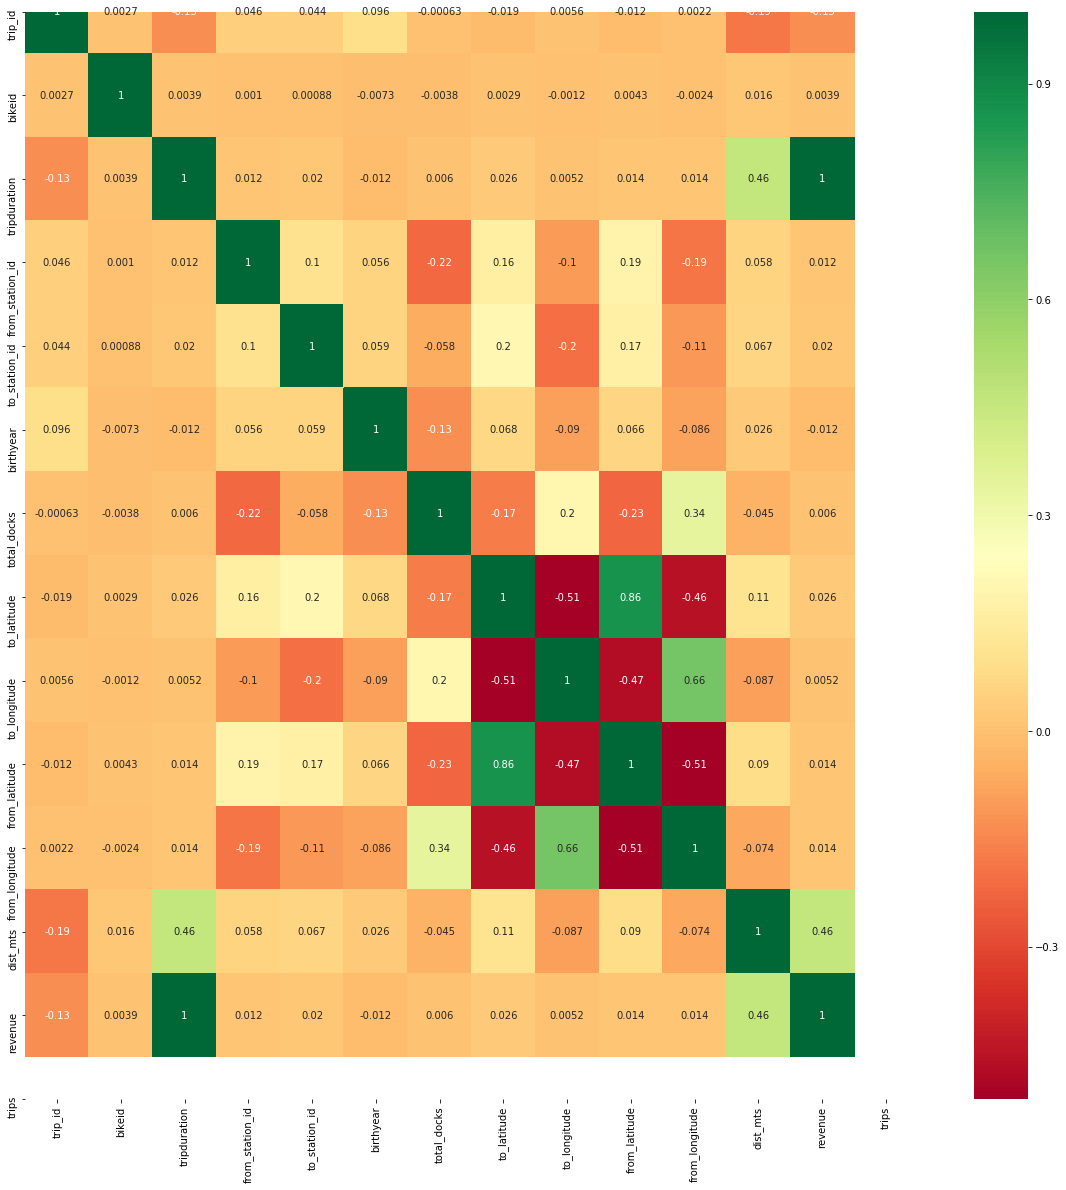

In [28]:
#get correlations of each features in dataset
corrmat = q2_stations.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(q2_stations[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [29]:
model = KNeighborsRegressor(n_neighbors=2, weights='distance')
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='distance')

In [30]:
#import the KNeighborsClassifier class from sklearn
from sklearn.neighbors import KNeighborsClassifier

#import metrics model to check the accuracy 
from sklearn import metrics
#Try running from k=1 through 25 and record testing accuracy
k_range = range(11,20)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train,y_train)
        y_pred=knn.predict(X_test)
        scores[k] = metrics.accuracy_score(y_test,y_pred)
        scores_list.append(metrics.accuracy_score(y_test,y_pred))

In [31]:
scores

{11: 0.40501574420315495,
 12: 0.39937634118464627,
 13: 0.39446394615660707,
 14: 0.3903773263110199,
 15: 0.386709194258266,
 16: 0.38361584653411157,
 17: 0.380822364150564,
 18: 0.3778766581051463,
 19: 0.375502681732906}

In [32]:
pred = knn.predict(X_test)

In [33]:
df_test["predicted_docks"] = pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
#Difference between existing and predicted docs

df_test["dock_diff"] = df_test["total_docks"] - df_test["predicted_docks"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df_test.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,to_latitude,to_longitude,from_latitude,from_longitude,dist_mts,revenue,trips,trips_per_day,predicted_docks,dock_diff
641505,21740889,2018-12-31 00:01:19,2018-12-31 00:14:32,4036,793.0,172,Rush St & Cedar St,49,Dearborn St & Monroe St,Subscriber,...,41.881320,-87.629521,41.902309,-87.627691,2336.204286,1.321667,1,0.00274,19.0,-8.0
641506,21740890,2018-12-31 00:03:45,2018-12-31 00:08:00,6250,255.0,72,Wabash Ave & 16th St,338,Calumet Ave & 18th St,Subscriber,...,41.857611,-87.619407,41.860384,-87.625813,614.649152,0.425000,1,0.00274,19.0,20.0
641507,21740891,2018-12-31 00:08:02,2018-12-31 00:13:35,2561,333.0,140,Dearborn Pkwy & Delaware Pl,180,Ritchie Ct & Banks St,Subscriber,...,41.906866,-87.626217,41.898969,-87.629912,929.172271,0.555000,1,0.00274,19.0,0.0
641508,21740892,2018-12-31 00:08:11,2018-12-31 00:13:30,1466,319.0,140,Dearborn Pkwy & Delaware Pl,180,Ritchie Ct & Banks St,Subscriber,...,41.906866,-87.626217,41.898969,-87.629912,929.172271,0.531667,1,0.00274,19.0,0.0
641509,21740893,2018-12-31 00:18:28,2018-12-31 00:25:16,767,408.0,60,Dayton St & North Ave,58,Marshfield Ave & Cortland St,Subscriber,...,41.916017,-87.668879,41.910578,-87.649422,1723.560056,0.680000,1,0.00274,15.0,4.0


Evaluation of classification quality

In [36]:
from sklearn.metrics import classification_report,confusion_matrix
conf_mat=confusion_matrix(y_test,pred)
print(conf_mat)

[[     0      0      0      1      0      5      1      0      1      0
       0      0      0      0]
 [     0   3487      0   8245      0   8276   3463   2208   5494   1166
    1682     39    337     91]
 [     0      0      0   1053      0   1583    437     97    120      7
      11     28     49      0]
 [     0   1324      0 173263      0  82081  32495  15191  26049   5566
    7574   1559   4948    736]
 [     0     96      0   1735      2    734    982     75    113     20
       1      1     35      0]
 [     0    872      0  87859      0 191429  39090  22377  40984   7869
   15292   3740   7078   1683]
 [     0    631      0  57182      0  71281  84420  16855  34560   4574
    8631   3130   8854    327]
 [     0    363      0  34805      0  46150  23617  60133  36081   7317
    8966   1270   6207    178]
 [     0    199      0  27568      0  44645  18934  18101 117287   9531
    9942    821  11048   1565]
 [     0     77      0  12495      0  17644   6493   6998  21479  22174
 

In [37]:
print(classification_report(y_test,pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         7.0       0.00      0.00      0.00         8
        11.0       0.47      0.10      0.17     34488
        12.0       0.00      0.00      0.00      3385
        15.0       0.40      0.49      0.44    350786
        16.0       1.00      0.00      0.00      3794
        19.0       0.37      0.46      0.41    418273
        23.0       0.36      0.29      0.32    290445
        27.0       0.38      0.27      0.31    225087
        31.0       0.36      0.45      0.40    259641
        35.0       0.33      0.22      0.26     99884
        39.0       0.33      0.28      0.30    120799
        43.0       0.44      0.27      0.33     44137
        47.0       0.38      0.36      0.37     80973
        55.0       0.64      0.34      0.44     32515

    accuracy                           0.38   1964215
   macro avg       0.39      0.25      0.27   1964215
weighted avg       0.38      0.38      0.37   1964215



In [38]:
print("Misclassification error rate:",round(np.mean(pred!=y_test),3))

Misclassification error rate: 0.624


Choosing 'k' by elbow method

In [39]:
error_rate = []

# Will take some time
for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error (misclassification) Rate')

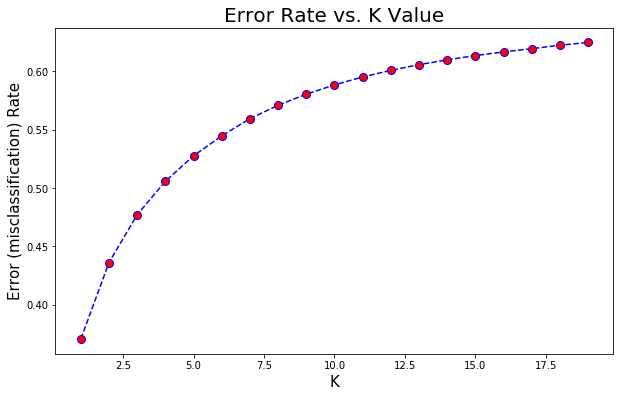

In [40]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value', fontsize=20)
plt.xlabel('K',fontsize=15)
plt.ylabel('Error (misclassification) Rate',fontsize=15)

Using LogisticRegression estimator from Scikit-learn

In [44]:
clf1 = LogisticRegression(penalty='l2',solver='newton-cg')

In [45]:
clf1.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
clf1.intercept_

array([-5.46549348e+02, -3.65244479e+02, -5.57643511e+02, -2.23220569e+03,
       -1.50041970e+03, -5.30236748e+02, -7.64275981e+02, -1.35547918e-01,
        2.57761338e+03,  3.28315587e+02,  3.51189882e+03,  1.95556735e+03,
        6.24319629e+02,  4.66455879e+03])

In [47]:
clf1.coef_

array([[ 7.65352440e-05, -2.41837158e-03, -1.87529945e-01,
        -5.93663626e+00,  1.45610041e-03],
       [ 4.04516176e-05,  9.26259851e-04,  2.80363038e+01,
        -3.21512117e+01,  4.53948393e-07],
       [-7.85667289e-04, -4.75736990e-03, -5.71117996e-01,
        -5.69627660e+00,  3.31312678e-05],
       [ 1.24486988e-04,  3.06335372e-04,  9.33389206e+00,
        -3.47850623e+01, -5.39083189e-02],
       [ 2.22377674e-05, -3.29858847e-03, -5.15073424e+00,
        -1.18682654e+01, -1.01226059e-04],
       [ 8.96393063e-07,  5.82501201e-04, -1.46877516e+00,
        -4.56588235e+00, -2.33313469e-02],
       [-3.60604860e-04,  9.83855211e-05, -3.48105214e-01,
        -8.35189417e+00,  2.18944409e-01],
       [-5.13991576e-04,  7.56457029e-05, -4.59037260e+00,
         4.61001747e+00, -8.56653226e-07],
       [ 8.23214471e-04, -8.19815966e-04, -1.02559308e+00,
         3.04574898e+01, -5.05997725e-01],
       [ 5.72960934e-05, -1.45784079e-04,  3.78308941e+00,
        -5.21348151e-03

In [48]:
clf1.score(X_test,y_test)

0.22288293287649263

For LogisticRegression estimator, there is a special predict_proba method which computes the raw probability values

In [49]:
prob_threshold = 0.5